## Configuración de paquetes base

In [ ]:
## General modules
import pandas as pd
import numpy as np
import time
import os
from scipy import stats as sp_stats
from sklearn.model_selection import train_test_split
import shutil
from google.colab import drive
import matplotlib.pyplot as plt

## Calibration modules
from sklearn import metrics
from sklearn import calibration

## Neural networks
import keras 
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model, Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import utils, applications
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
## GoogleDrive Connection
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración de paquetes de Github

In [ ]:
## Install calibration package
!pip install git+https://github.com/uu-sml/calibration.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/uu-sml/calibration.git to /tmp/pip-req-build-iddcge96
  Running command git clone --filter=blob:none --quiet https://github.com/uu-sml/calibration.git /tmp/pip-req-build-iddcge96
  Resolved https://github.com/uu-sml/calibration.git to commit 7bd1a2407f96f87e37d81eadaea7efeb14bb8a83
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.0 MB/s eta 0:00:00
  Created wheel for calibration: filename=calibration-0.0.1-py3-none-any.whl size=16891 sha256=95febd30f8124eaaf99544df7456bc580f25ba9029792e14ca9188fe50c73b86
  Stored in directory: /tmp/pip-ephem-wheel-cache-3840u0qy/wheels/ea/67/e0/9f3de41456f07fb81268b88a9adad2069f4fc3b7dcab126433
Successfully built calibration


El paquete de _calibration_ tal cual como viene de github, no trae la carpeta de _utils_ donde están las distancias que se pueden utilizar. Adicionalmente, la inicialización del paquete no contiene nada, por lo cual se debe solucionar este problema con los siguientes.

In [ ]:
## Path in where files to fix clone of calibration module are
path_in = "/content/drive/MyDrive/Trabajo de Grado Maestría/Librería Calibration/"

## Path out where files to fix clone of calibration module have to be
path_out = "/usr/local/lib/python3.8/dist-packages/calibration/"

## Create folder 
if not os.path.isdir(path_out + "utils"):
  os.mkdir(path_out + "utils")

## Copy files
shutil.copyfile(path_in + "distances.py", path_out + "utils/distances.py")
shutil.copyfile(path_in + "__init__.py", path_out + "utils/__init__.py")

'/usr/local/lib/python3.8/dist-packages/calibration/utils/__init__.py'

In [ ]:
## Calibration functions
import calibration.stats as cali_stats
import calibration.utils as cali_utils
import calibration.binning as cali_binning
import calibration.sample as cali_sample
import calibration.lenses as cali_lenses 

In [ ]:
#===================================#
#     Class-wise ECE for tensors    #    
#===================================#
def cwECE_tf(y_true, y_pred):
  n_bins = 15
  
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = 0.0

  ## Calculate ECE for each class
  for k in range(y_pred.shape[1]):
    ## Store probs and observations
    confidences = y_pred[:,k]
    accuracies = y_pred[:,k] == 1

    ece = 0.0
    # ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
      prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

      if prop_in_bin > 0:
          accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
          avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
          ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    ## Store values 
    ece_list += ece

  ece_list = ece_list/y_pred.shape[1]

  return ece_list

#========================================#
#   Maximum confidence ECE for tensors   #
#========================================#
def maxECE_tf(y_true, y_pred):
  n_bins = 15

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = tf.math.reduce_max(y_pred, axis = 1)
  predictions = tf.math.argmax(y_pred, axis = 1)
  accuracies = predictions == tf.math.argmax(y_true, axis = 1)

  ## Confidence and predictions in each bin
  ece = 0.0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
    prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

    if prop_in_bin > 0:
        accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
        avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
        ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      
  return ece

#================================#
#          Class-wise ECE        #
#================================#
def cwECE(n_bins, probs, obs, metric):
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = []

  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Calculate ECE for each class
  for k in range(probs.shape[1]):
    
    ## Store probs and observations
    confidences = probs[:,k]
    accuracies = obs[:,k] == 1

    ## Lists to store values to plot the reliability diagram
    conf = []
    acc = []
    bin = []

    ece = 0
    ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):       
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower)*(confidences <= bin_upper)      
      prop_in_bin = np.mean(in_bin)
      if prop_in_bin > 0:
        accuracy_in_bin = np.mean(accuracies[in_bin])
        avg_confidence_in_bin = np.mean(confidences[in_bin])
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        conf += [avg_confidence_in_bin]
        acc += [accuracy_in_bin]
        bin += [(bin_lower + bin_upper)/2]        
        del in_bin, prop_in_bin, accuracy_in_bin, avg_confidence_in_bin
    ## Store values
    conf_list += [conf]
    acc_list += [acc]
    bin_list += [bin]    
    ece_list += [ece]
    del conf, acc, bin, ece
  
  if metric is True:
    return np.mean(ece_list)
  else:
    return ece_list, conf_list, acc_list, bin_list

#================================#
#    Maximum confidence ECE      #
#================================#
def maxECE(n_bins, probs, obs, metric):
  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = probs.max(axis = 1)
  predictions = probs.argmax(axis = 1)
  accuracies = probs.argmax(axis = 1) == obs.argmax(axis = 1)

  ## Confidence and predictions in each bin
  ece = 0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower)*(confidences <= bin_upper)
    prop_in_bin = np.mean(in_bin)  

    if prop_in_bin > 0:
      accuracy_in_bin = np.mean(accuracies[in_bin])
      avg_confidence_in_bin = np.mean(confidences[in_bin])
      ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      conf_list += [avg_confidence_in_bin]
      acc_list += [accuracy_in_bin]
      bin_list += [(bin_lower + bin_upper)/2]   

  if metric is True:
    return ece
  else: 
    return ece, conf_list, acc_list, bin_list

#========================#
#   Brier multiclass     #
#========================#
def brier_multi(targets, probs):
  """ 
  targets: Numpy array of one-hot encoding of observed labels with shape (n, classes)
  probs: Numpy array of probs for each class with shape (n, classes)
  """
  return np.mean(np.sum((probs - targets)**2, axis = 1))

#================================================#
#   Function to calculate calibration metrics    #
#================================================#
def resume_metrics(X_test, Y_test, T_test, model, nbins):
  """
  Arguments:
    X_test    : Covariates for testing (n,p)
    Y_test    : Target variable dimension for testing (n,)
    T_test    : One hot encoding of the target variable dimension for testing (n,c)

    model     : Model object that contains .predict function to obtain the probabilities for each class    
    nbins     : Number of equally sized bins created

  where: 
    c: Number of classes
    p: number of covariates
    n: Number of observations

  It returns a tuple with pandas data.frames with results of calibration metrics 
  """
  
  #==============================================#
  #                 Organize data                #
  #==============================================#
  ## Predictions on test
  pred_test = model.predict(X_test)
  
  ## Most confident probability predictions (Maximum lenses)
  pred_test_max, T_test_max = cali_lenses.maximum_lens(probs = pred_test, y = T_test)

  #=============================================================================#
  #                  Expected Calibration Error                                 #
  #=============================================================================#
  ## Cambiar nombres
  ## ECE + dependent binning + tvdistance
  ece_max_uni = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean"))

  ## ECE + uniform binning + tvdistance
  ece_max_dep = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.UniformBinning(bins = nbins))

  ## cwECE + uniform binning
  ece_cw_uni = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = True)

  #======================================================#
  #       Samples under perfect calibration (ECE)        #
  #======================================================#
  np.random.seed(6164)
  ## ECE + dependent binning + tvdistance
  # Define Resampling
  resample = cali_sample.ResampleStats(
      lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance,
                               binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean")),
                               n = 1000)
  
  # Generate samples
  ece_max_dep_sample = resample(pred_test_max)
  del resample

  ## ECE + uniform binning + tvdistance
  # Define Resampling
  resample = cali_sample.ResampleStats(
      lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance, 
                               binning = cali_binning.UniformBinning(bins = nbins)),
                               n = 1000)

  # Generate samples
  ece_max_uni_sample = resample(pred_test_max)
  del resample

  ## cw-ECE + uniform binning
  # Define Resampling
  resample = cali_sample.ResampleStats(lambda x: cwECE(n_bins = nbins, probs = x, obs = T_test, metric = True), n = 1000)

  # Generate samples
  ece_cw_uni_sample = resample(pred_test)

  #====================================================================#
  #    P-value of ECE under assumption of perfect calibration (ECE)    #
  #====================================================================#
  ## Data dependent binning + tv distance
  p_data_max = 1 - sp_stats.percentileofscore(ece_max_dep_sample, ece_max_dep)/100

  ## Uniform binning + tv distance
  p_uni_max = 1 - sp_stats.percentileofscore(ece_max_uni_sample, ece_max_uni)/100

  ## Uniform binning + tv distance
  p_uni_cw = 1 - sp_stats.percentileofscore(ece_cw_uni_sample, ece_cw_uni)/100
  
  #==================================#
  #          Brier score             #
  #==================================#  
  ## Brier for all classes
  bri_full = brier_multi(targets = T_test, probs = pred_test)

  ## Brier for most confidence class
  bri_max = brier_multi(targets = T_test_max, probs = pred_test_max)

  #===========================#
  #           Log Loss        #
  #===========================#
  loss_full = metrics.log_loss(y_true = T_test, y_pred = pred_test)
  loss_maxx = metrics.log_loss(y_true = T_test_max, y_pred = pred_test_max)

  #=================================================#
  #                 Reliability Diagram             #
  #=================================================#
  ## Class-wise reliability diagram and ECE individually
  cw_ece_list, cw_conf_list, cw_acc_list, cw_bin_list = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = False)

  ## Most confident prediction 
  max_ece, max_conf_list, max_acc_list, max_bin_list = maxECE(n_bins = nbins, probs = pred_test_max, obs = T_test_max, metric = False)

  ## Organize data
  diag_cw = pd.DataFrame({"ece" : cw_ece_list, "conf" : cw_conf_list, "acc" : cw_acc_list, "bin" : cw_bin_list})
  diag_max = pd.DataFrame({"ece" : max_ece, "conf" : max_conf_list, "acc" : max_acc_list, "bin" : max_bin_list})

  #=============================#
  #   Combine all the results   #
  #=============================#
  ## Combine results
  global_metrics_ece = pd.DataFrame({
      "Approach" : ["Maximum","Maximum","CW"],
      "Distance" : ["TV","TV","-"],
      "Binning" : ["Data","Uniform","Uniform"],
      "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
      "ECE perfcect mean" : [np.mean(ece_max_dep_sample), np.mean(ece_max_uni_sample), np.mean(ece_cw_uni_sample) ],
      "ECE perfcect std" : [np.std(ece_max_dep_sample), np.std(ece_max_uni_sample), np.std(ece_cw_uni_sample) ],
      "ECE p-value" : [p_data_max, p_uni_max, p_uni_cw] })
  
  global_metrics = pd.DataFrame({
      "Brier_full" : [bri_full],
      "Brier_maximum" : [bri_max],
      "Log-loss_full" : [loss_full],
      "Log-loss_maximum" : [loss_maxx] })
  
  return global_metrics, global_metrics_ece, diag_max, diag_cw

#=================================================#
#         Reliability Diagram Function            #
#=================================================#  
plt.style.use('seaborn-darkgrid')

def ReliabilityDiagram(df_gram, diagram, nr_plt, nc_plt, w_plt, h_plt):
  """ 
  Function to plot the reliability diagram for the most confident prediction or
  for the class-wise results.

  df_gram: Pandas dataframe with the data to plot
  diagram: Whether "max" or "cw" reliability diagram
  nr_plt: Number of row plots for the classwise option
  nc_plt: Number of column plots for the classwise option
  w_plt: Size of the width of the figure
  h_plt: Size of the height of the figure
  """

  ##=========== Reliability diagram (most confident prediction)
  if diagram == "max":
    dd = df_gram
    ece = np.round(df_gram.loc[:,"ece"].tolist()[0],4)
    n_bins = 15

    plt.figure(figsize = (w_plt, h_plt))

    plt.plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
    plt.bar(dd["bin"], dd["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
    plt.text(0.05, 0.9, f"ECE-uniform: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
    plt.ylabel("Average Accuracy")
    plt.xlabel("Average Confidence")
    plt.title("ECE-uniform", fontsize = 18)

    # plt.show()

  ##=========== Reliability diagram (classwise)
  if diagram == "cw":
    dd = df_gram
    n_bins = 15

    fig, ax = plt.subplots(nr_plt, nc_plt, sharey = True, sharex = True, figsize = (w_plt, h_plt))

    if nr_plt == 1:
      for i in range(nc_plt):
        ece = np.round(df_gram.iloc[i,:]["ece"],4)

        ax[i].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
        ax[i].bar(dd.iloc[i,:]["bin"], dd.iloc[i,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
        ax[i].set_title(f"Class {str(i)}")
        ax[i].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
        ax[i].set_ylabel("Average Accuracy")
        ax[i].set_xlabel("Average Confidence")
    else:
      c = 0
      for i in range(nr_plt):
        for j in range(nc_plt):
          if c < dd.shape[0]:
            ece = np.round(df_gram.iloc[c,:]["ece"],4)

            ax[i,j].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
            ax[i,j].bar(dd.iloc[c,:]["bin"], dd.iloc[c,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
            ax[i,j].set_title(f"Class {str(c)}")
            ax[i,j].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white",'alpha': 1, 'pad': 10})
            ax[i,j].set_ylabel("Average Accuracy")
            ax[i,j].set_xlabel("Average Confidence")
            c += 1        
          else:
            ax[i,j].set_visible(False)

    fig.suptitle("Classwise ECE", fontsize = 20)
    fig.show()

  return None

## Carga datos CIFAR-10

In [ ]:
#====================#
#      Load data     #
#====================#
## Load data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

## Normalize data
X_train = X_train/255
X_test = X_test/255

## Reshape data 
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

## Train-validation split
X_dev, X_val, Y_dev, Y_val = train_test_split(X_train, Y_train, test_size = 0.10, shuffle = True, random_state = 2019) 

## Sustract mean
x_train_mean = np.mean(X_dev, axis=0)
train_mean = x_train_mean
X_dev -= train_mean
X_val -= train_mean
X_test -= train_mean

## Get columns in classes as dummies
T_test = pd.get_dummies(Y_test).values
T_dev = pd.get_dummies(Y_dev).values
T_val = pd.get_dummies(Y_val).values

del x_train_mean

## Print shapes
print("Shape X train + validation: ", X_train.shape)
print("Shape Y train + validation: ", Y_train.shape, "\n")
print("Shape X train: ", X_dev.shape)
print("Shape Y train: ", Y_dev.shape, "\n")
print("Shape X validation: ", X_val.shape)
print("Shape Y validation: ", Y_val.shape, "\n")
print("Shape Y test: ", Y_test.shape)
print("Shape X test: ", X_test.shape)

170498071/170498071 [==============================] - 14s 0us/step
Shape X train + validation:  (50000, 32, 32, 3)
Shape Y train + validation:  (50000,) 

Shape X train:  (45000, 32, 32, 3)
Shape Y train:  (45000,) 

Shape X validation:  (5000, 32, 32, 3)
Shape Y validation:  (5000,) 

Shape Y test:  (10000,)
Shape X test:  (10000, 32, 32, 3)


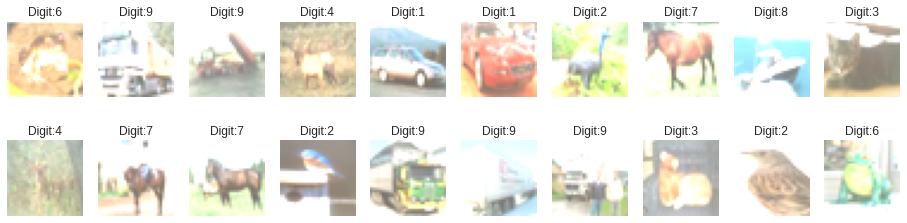

In [ ]:
#==================#
#    Plot data     #
#==================#
X = X_train + train_mean
Y = Y_train

fig = plt.figure(figsize = (16,4) )
for i in range(20):
  plt.subplot(2, 10, i+1)
  plt.imshow(X[i])
  plt.title('Digit:{}'.format(Y[i]))
  plt.xticks([])
  plt.yticks([])

del X, Y

## LeNet

Para esta arquitectura se revisaron varios blogs y demás donde usaban la arquitectura LeNet, pero en este [blog](https://bit.ly/3Sw2G73) se encuentra lo más parecida al paper original. Aunque no dice nada de la configuración para el entrenamiento, en el [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) original dicen que entrenan con una función de pérdida MSE y de optimizador SGD.

### Directory to store results

In [ ]:
#===========================#
# Directory to save results #
#===========================#
dir = "/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/02_LeNet/CIFAR-10/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

name_file = "lenet"

print(dir)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/02_LeNet/CIFAR-10/


### Callbacks configuration

In [ ]:
#=============================#
# Function to reduce the lr   #
#=============================#
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.01
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr

In [ ]:
#===================================#
#     Configuration of callbacks    #
#===================================#
## Early stopping
stop = EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 15,
        verbose = 0,
        mode = "auto",
        baseline = None,
        restore_best_weights = False)

## Checkpoint to save best model
checkpoint = ModelCheckpoint(filepath = dir,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True)

## Learning rate scheduler to reduce lr for some epochs
lr_scheduler = LearningRateScheduler(lr_schedule)

## Function to reduce the learning rate if it doesn't improve
lr_reducer = ReduceLROnPlateau(factor = 0.1, # np.sqrt(0.1)
                               cooldown = 0,
                               patience = 10,
                               min_lr = 0.5e-6)

## Join all the functions
callbacks = [lr_reducer] # lr_scheduler #  # 

### Data Augmentation

In [ ]:
#=======================#
#   Data Augmentation   #
#=======================#
datagen = ImageDataGenerator(
    ## Randomly shift images horizontally
    width_shift_range = 0.1,
    ## Randomly shift images vertically
    height_shift_range = 0.1,
    ## Randomly flip images
    horizontal_flip = True,         
    ## Fraction of images reserved for validation (strictly between 0 and 1)
    validation_split = 0.0)

## Train image generator
datagen.fit(X_dev)

### Training

In [ ]:
## Fix parameters
batch_size = 256
n_epochs = 150
n_repetitions = 10

In [ ]:
#================================#
#     Training of network        #
#================================#

global_metrics_full = pd.DataFrame()
global_metrics_ece_full = pd.DataFrame()
diag_max_full = pd.DataFrame()
diag_cw_full = pd.DataFrame()
his_full = pd.DataFrame()

for rr in range(n_repetitions):
  keras.backend.clear_session()

  ## Timestamp to get excecution time
  start_time = time.time()

  ## LeNet
  inputs = tf.keras.Input(shape = (32,32,3))

  x = tf.keras.layers.Conv2D(filters = 6, kernel_size = (5,5), strides=(1,1), activation = 'tanh')(inputs)
  x = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)

  x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (5,5), strides = (1,1), activation = 'tanh')(x)
  x = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(units = 120, activation = 'tanh')(x)
  x = tf.keras.layers.Dense(units = 84, activation = 'tanh')(x)
  x = tf.keras.layers.Dense(units = 10, activation = 'linear')(x)  # softmax

  model = keras.Model(inputs = inputs, outputs = x)

  ## Compile
  model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.005),  metrics = ['accuracy', maxECE_tf, cwECE_tf]) 

  ## Build model
  model.build(input_shape = (32,32,3))

  ## Fit the model on the batches generated by datagen.flow().
  history = model.fit(datagen.flow(X_dev, T_dev, batch_size = batch_size), validation_data = (X_val, T_val), epochs = n_epochs, callbacks = callbacks, verbose = 0)

  ## Arrange results of history
  his_aux = pd.DataFrame(history.history)
  his_aux["epochs"] = range(1, his_aux.shape[0]+1) 
  his_aux["train_acc_final"] = metrics.accuracy_score(y_true = Y_dev, y_pred = model.predict(X_dev).argmax(axis = 1))
  his_aux["val_acc_final"] = metrics.accuracy_score(y_true = Y_val, y_pred = model.predict(X_val).argmax(axis = 1))
  his_aux["repetition"] = rr

  his_full = pd.concat((his_full, his_aux), ignore_index = True)

  ## Calibration metrics
  global_metrics, global_metrics_ece, diag_max, diag_cw = resume_metrics(X_test = X_test, Y_test = Y_test, T_test = T_test, model = model, nbins = 15)
  
  global_metrics["repetition"] = rr
  global_metrics_ece["repetition"] = rr
  diag_max["repetition"] = rr
  diag_cw["repetition"] = rr

  global_metrics_full = pd.concat((global_metrics_full, global_metrics), ignore_index = True)
  global_metrics_ece_full = pd.concat((global_metrics_ece_full, global_metrics_ece), ignore_index = True)
  diag_max_full = pd.concat((diag_max_full, diag_max), ignore_index = True)
  diag_cw_full = pd.concat((diag_cw_full, diag_cw), ignore_index = True)

  ## Export results
  his_full.to_csv(dir + "history_parameters.csv")

  global_metrics_full.to_feather(dir + "global_metrics.feather")
  global_metrics_ece_full.to_feather(dir + "global_metrics_ece.feather")
  diag_max_full.to_feather(dir + "diagram_max.feather")
  diag_cw_full.to_feather(dir + "diagram_cw.feather")

  model.save(dir + "model_" + str(rr) + ".h5")

  del x, history, global_metrics, global_metrics_ece, diag_max, diag_cw, his_aux, model

  print(f"=======  Done {rr}; Duration { (time.time() - start_time)/60:.2f} (minutes) =================")

=======  Done 0; Duration 57.67 (minutes) =================
=======  Done 1; Duration 57.32 (minutes) =================
=======  Done 2; Duration 57.88 (minutes) =================
=======  Done 3; Duration 58.47 (minutes) =================
=======  Done 4; Duration 57.61 (minutes) =================
=======  Done 5; Duration 57.59 (minutes) =================
=======  Done 6; Duration 56.29 (minutes) =================
=======  Done 7; Duration 56.47 (minutes) =================
=======  Done 8; Duration 55.77 (minutes) =================
=======  Done 9; Duration 55.56 (minutes) =================


### Results

In [ ]:
global_metrics_full = pd.read_feather(dir + "global_metrics.feather")
global_metrics_ece_full = pd.read_feather(dir + "global_metrics_ece.feather")
diag_max_full = pd.read_feather(dir + "diagram_max.feather")
diag_cw_full = pd.read_feather(dir + "diagram_cw.feather")

In [ ]:
## Read parameter history to check which combination was better
his_aux = pd.read_csv(dir + "history_parameters.csv", index_col = 0)

## Select parameters of each combination and its results
his_aux[['repetition','train_acc_final', 'val_acc_final']]\
  .drop_duplicates()

,repetition,train_acc_final,val_acc_final
0,0,0.625000,0.5918
150,1,0.636133,0.5932
300,2,0.632800,0.5890
450,3,0.652378,0.6138
600,4,0.647533,0.6010
750,5,0.622400,0.5812
900,6,0.650956,0.6090
1050,7,0.627378,0.5860
1200,8,0.618156,0.5782
1350,9,0.633378,0.5912


In [ ]:
## Best repetition according to the accuracy of validation
dd = his_aux[['repetition','train_acc_final', 'val_acc_final']].drop_duplicates()

best_rr = dd.loc[dd["val_acc_final"] == np.max(dd["val_acc_final"]),:]["repetition"]
best_rr = best_rr.tolist()[0]

print(f"Best repetition: {best_rr}")

Best repetition: 3


In [ ]:
## Metrics of calibration for the best repetition
global_metrics_full.loc[global_metrics_full["repetition"] == best_rr,:]

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,repetition
3,0.519918,0.374464,1.415364,0.558336,3


In [ ]:
## Metrics of calibration for the best repetition
global_metrics_ece_full.loc[global_metrics_ece_full["repetition"] == best_rr,:]

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value,repetition
9,Maximum,TV,Data,0.033722,0.012854,0.002473,0.0,3
10,Maximum,TV,Uniform,0.033748,0.011713,0.002471,0.0,3
11,CW,-,Uniform,0.011893,0.094520,0.000765,1.0,3


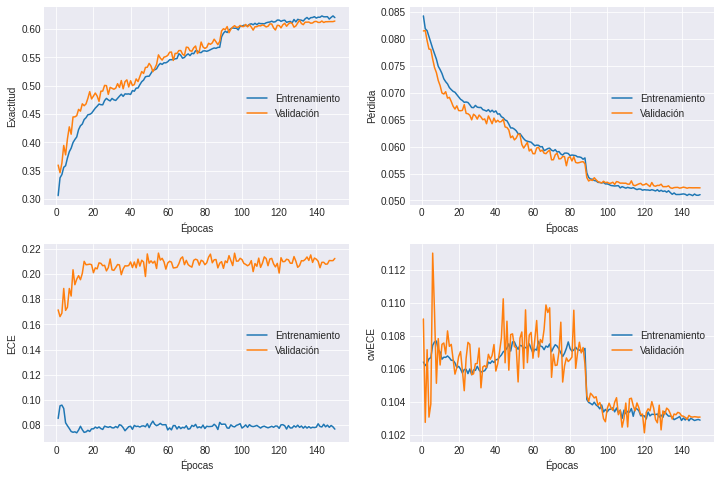

In [ ]:
## Plot history of best experiment

## Select best experiment
his_unique = his_aux.loc[his_aux["repetition"] == best_rr,:]

## Plot
fig, axis = plt.subplots(2,2, figsize = (12,8))

axis[0,0].plot(his_unique["epochs"], his_unique["accuracy"], label = "Entrenamiento")
axis[0,0].plot(his_unique["epochs"], his_unique["val_accuracy"], label = "Validación")
axis[0,0].set_xlabel("Épocas")
axis[0,0].set_ylabel("Exactitud")
axis[0,0].legend(loc = "center right")

axis[0,1].plot(his_unique["epochs"], his_unique["loss"], label = "Entrenamiento")
axis[0,1].plot(his_unique["epochs"], his_unique["val_loss"], label = "Validación")
axis[0,1].set_xlabel("Épocas")
axis[0,1].set_ylabel("Pérdida")
axis[0,1].legend(loc = "center right")

axis[1,0].plot(his_unique["epochs"], his_unique["maxECE_tf"], label = "Entrenamiento")
axis[1,0].plot(his_unique["epochs"], his_unique["val_maxECE_tf"], label = "Validación")
axis[1,0].set_xlabel("Épocas")
axis[1,0].set_ylabel("ECE")
axis[1,0].legend(loc = "center right")

axis[1,1].plot(his_unique["epochs"], his_unique["cwECE_tf"], label = "Entrenamiento")
axis[1,1].plot(his_unique["epochs"], his_unique["val_cwECE_tf"], label = "Validación")
axis[1,1].set_xlabel("Épocas")
axis[1,1].set_ylabel("cwECE")
axis[1,1].legend(loc = "center right")

plt.savefig(dir + 'history_' + name_file + '.pdf', bbox_inches='tight')
plt.show()

del his_unique

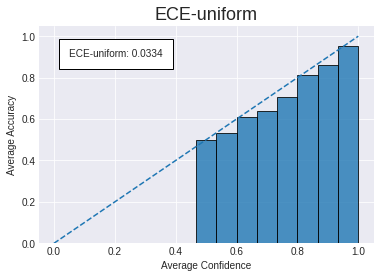

In [ ]:
## Reliability diagram (classwise)
ReliabilityDiagram(diag_max_full.loc[diag_max_full["repetition"] == best_rr,:], diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)
plt.savefig(dir + 'dmax_' + name_file + '.pdf', bbox_inches='tight')

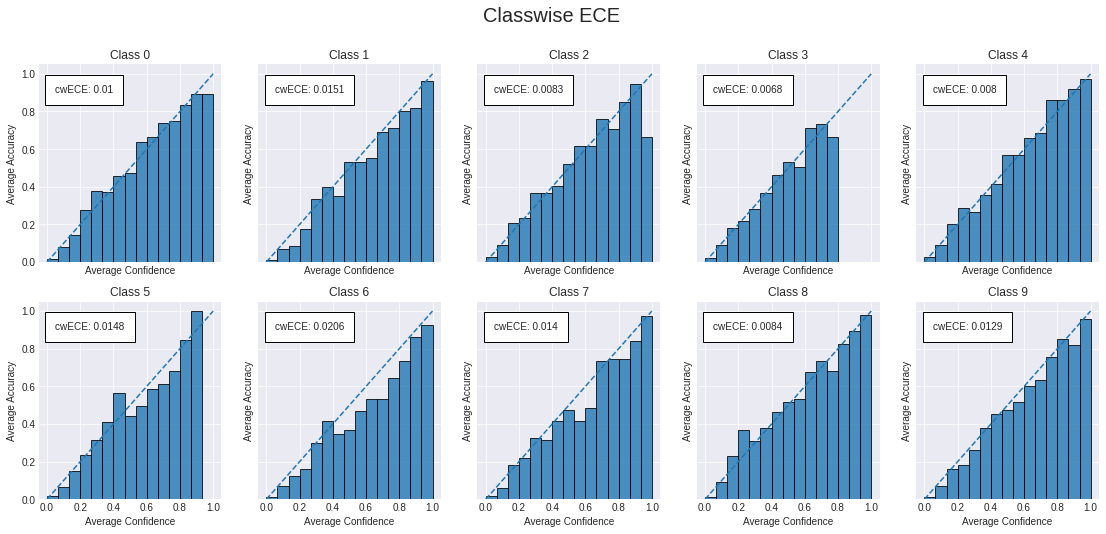

In [ ]:
## Reliability diagram (classwise)
ReliabilityDiagram(diag_cw_full.loc[diag_cw_full["repetition"] == best_rr,:], diagram = "cw", nr_plt = 2, nc_plt = 5, w_plt = 19, h_plt = 8)
plt.savefig(dir + 'dcw_' + name_file + '.pdf', bbox_inches='tight')

In [ ]:
## Import model
model = load_model(dir + "model_" + str(best_rr) + ".h5", custom_objects={"maxECE_tf" : maxECE_tf, "cwECE_tf" : cwECE_tf})
model.count_params()
# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

62006

In [ ]:
acc_train = metrics.accuracy_score(y_true = Y_dev, y_pred = model.predict(X_dev).argmax(axis = 1))
acc_val = metrics.accuracy_score(y_true = Y_val, y_pred = model.predict(X_val).argmax(axis = 1))
acc_test = metrics.accuracy_score(y_true = Y_test, y_pred = model.predict(X_test).argmax(axis = 1))

print(f"Training: {acc_train:.3f}\nValidation: {acc_val:.3f}\nTest: {acc_test:.3f}")

Training: 0.652
Validation: 0.614
Test: 0.617
